## Eigenfaces

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gif2numpy
import cv2
from math import ceil
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
folder = 'C:/Users/Vahram Babajanyan/Desktop/yalefaces/'

In [2]:
#This class does all the processing
class EigenFaces:
    def __init__(self,folder,token,eigenfaces, include_test = False):
        self.folder = folder
        self.token = token
        self.include_test = include_test
        self.eigenfaces = eigenfaces
    def read_and_downsample(self):
        all_images = os.listdir(self.folder)
        relevant_images = [image for image in all_images if self.token in image]
        if self.include_test:
            pass
        else:
            relevant_images = [image for image in relevant_images if 'test' not in image]
            
        all_converted = {}
        for image in relevant_images:
            all_converted[image[:-4]] = gif2numpy.convert(folder + image)[0][0]
            
        for key in all_converted.keys():
            all_converted[key] = cv2.pyrDown(all_converted[key])
            all_converted[key] = cv2.pyrDown(all_converted[key])
            
        self.all_converted = all_converted
        self.size = len(all_converted.keys())
        self.shape1 = all_converted[key].shape[0]
        self.shape2 = all_converted[key].shape[1]
        self.shape3 = all_converted[key].shape[2]
    def merge_images(self):
        all_converted = self.all_converted.copy()
        for key in all_converted.keys():
            all_converted[key] = all_converted[key].reshape(-1)
        first_key = next(iter(all_converted))
        merge = all_converted[first_key]
        del all_converted[key]
        for key in all_converted.keys():
            merge = np.vstack((merge, all_converted[key]))
        self.merge = merge
    def visualize_original_images(self):
        plt.figure(figsize=(15, 4 * ceil(self.size / 3)), tight_layout = True)
        for index,key in enumerate(self.all_converted.keys()):
            plt.subplot(ceil(self.size / 3), 3, index+1)
            plt.imshow(self.all_converted[key])
            plt.xticks([])  
            plt.yticks([])  
    def get_eigenfaces(self):
        model = PCA(n_components = self.eigenfaces, whiten = True)
        model.fit(self.merge.T)
        
        all_eigenfaces = model.transform(self.merge.T)
        all_eigenfaces = MinMaxScaler().fit_transform(all_eigenfaces)
        self.all_eigenfaces = all_eigenfaces
    def visualize_eigenfaces(self):
        plt.figure(figsize=(10, 4 * ceil(self.eigenfaces / 3)), tight_layout = True)
        for i in range(self.eigenfaces):
            plt.subplot(ceil(self.eigenfaces / 3), 3, i+1)
            plt.imshow(self.all_eigenfaces[:,i].reshape(self.shape1,self.shape2,self.shape3))
            plt.xticks([])  
            plt.yticks([])
    def process(self):
        EigenFaces.read_and_downsample(self)
        EigenFaces.merge_images(self)
        EigenFaces.get_eigenfaces(self)
        
        return 'Processed'
    
    @property
    def merge_(self):
        return self.merge
    @property
    def converted_(self):
        return self.all_converted
    @property
    def eigenfaces_(self):
        return self.all_eigenfaces


#### Subject1

In [3]:
subject1 = EigenFaces(folder,'subject01', eigenfaces = 6)
subject1.process()

'Processed'

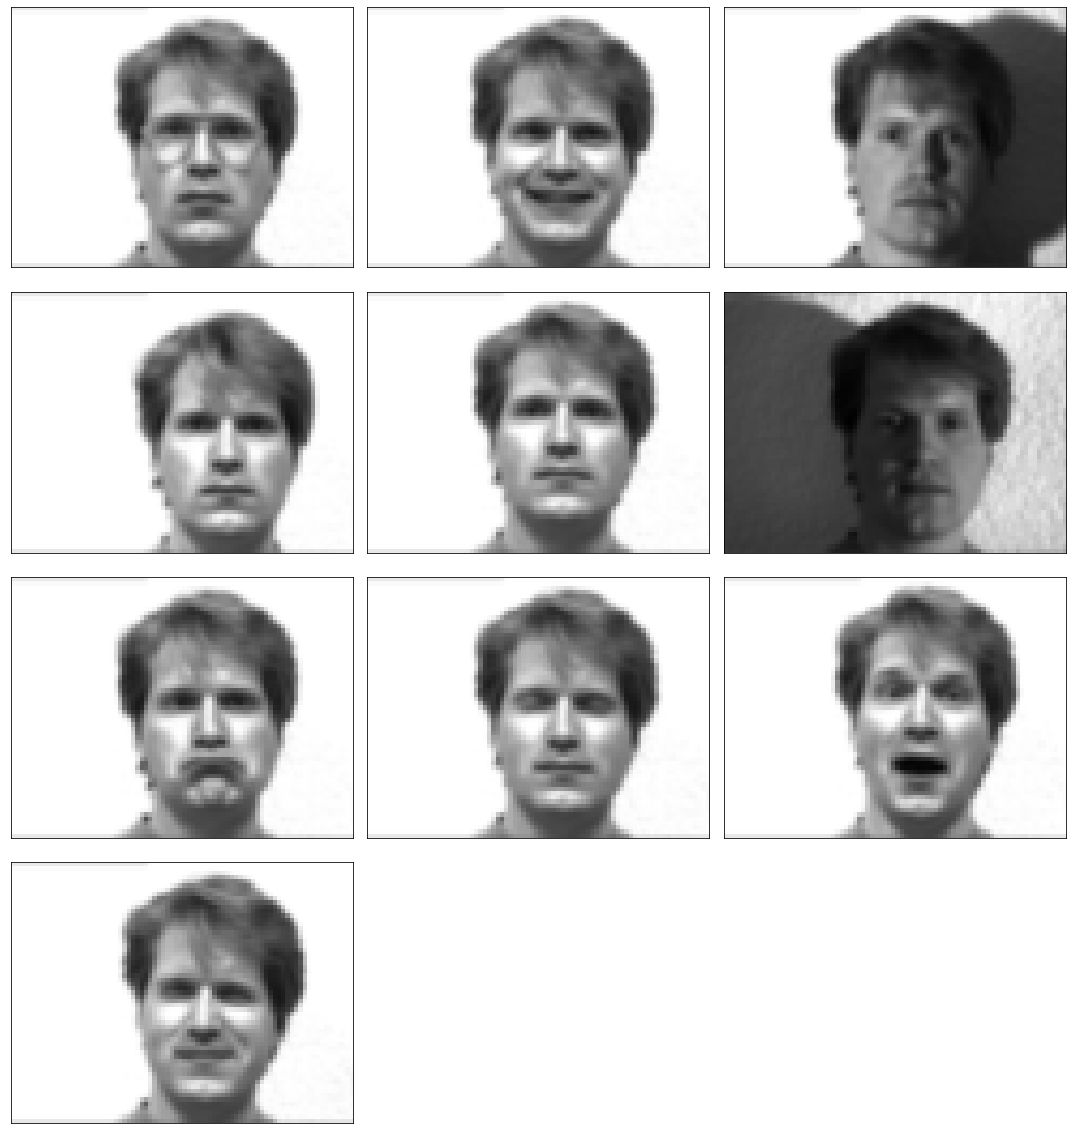

In [4]:
subject1.visualize_original_images()

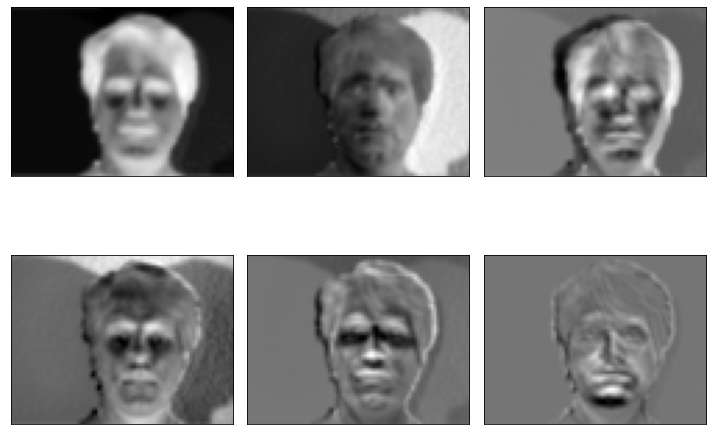

In [5]:
subject1.visualize_eigenfaces()

#### Subject2

In [6]:
subject2 = EigenFaces(folder,'subject02', eigenfaces = 6)
subject2.process()

'Processed'

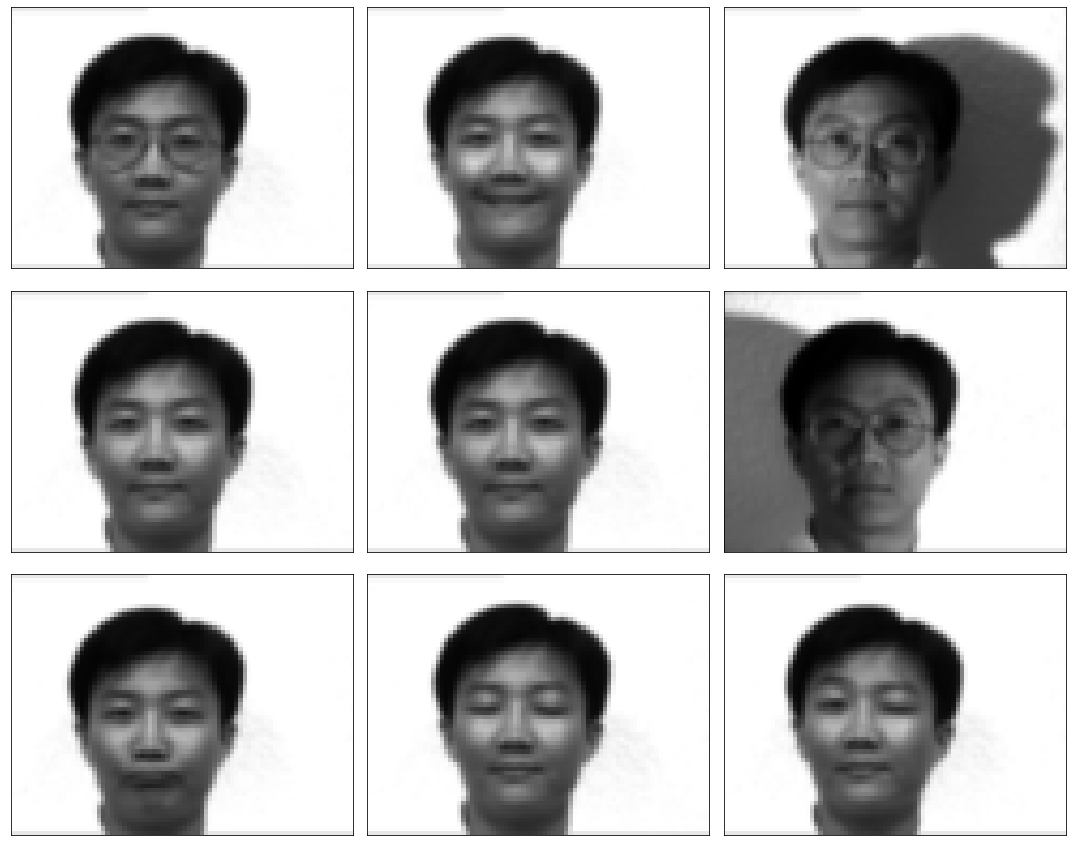

In [7]:
subject2.visualize_original_images()

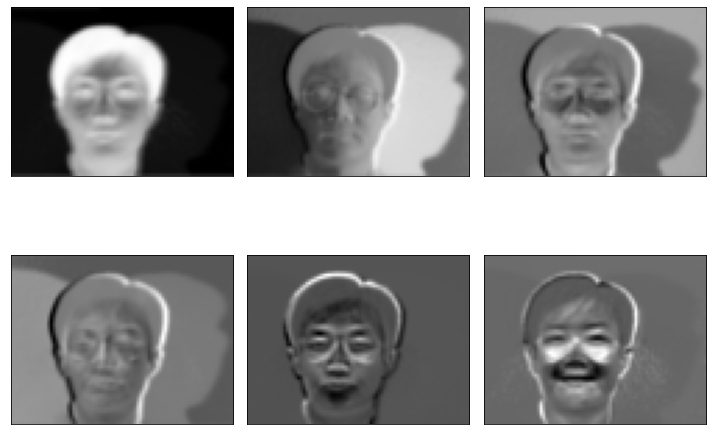

In [8]:
subject2.visualize_eigenfaces()

As regards to patterns in these eigenfaces, one thing is clear - The more variance the eigenvector explains the less complicated are the features represented by it. In other words seems like each next component tries to add an additional layer to the basement, diving more and more into details as the explained variance for each component decreases.

### Face Recognition

In [9]:
def process_test(folder,image):
    converted = gif2numpy.convert(folder + image)[0][0]
    
    converted = cv2.pyrDown(converted)
    converted = cv2.pyrDown(converted)
    
    flattened = converted.reshape(-1,1)
    final = MinMaxScaler().fit_transform(flattened).reshape(-1)
    return final

def projection_residual(test,eigenfaces):
    test_size = len(test)
    eigen_size = len(eigenfaces)
    values = []
    for j in range(test_size):
        for i in range(eigen_size):
            values += [np.linalg.norm(test[j] - eigenfaces[i]*eigenfaces[i].T*test[j])]
    values = np.array(values)
    values = values.reshape(test_size,eigen_size)
    values = pd.DataFrame(values, index = np.arange(1,test_size+1), columns = np.arange(1,eigen_size+1))
    return values.T
        

In [10]:
subject1_eigenvector = subject1.eigenfaces_[:,0]
subject2_eigenvector = subject2.eigenfaces_[:,0]

In [11]:
test1 = 'subject01-test.gif'
test2 = 'subject02-test.gif'

test1_vector = process_test(folder,test1)
test2_vector = process_test(folder,test2)

In [12]:
test = [test1_vector, test2_vector]
eigenfaces = [subject1_eigenvector,subject2_eigenvector]
projection_residual(test,eigenfaces)

,1,2
1,92.424935,88.944003
2,85.332142,96.665010


Well, I'm not even sure if I did all the calculations right, however I think the 2 subjects may predict each other's test-images more accuractely than their owns, because the residuals on the main diagonal are higher.

## Spam Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import OneClassSVM

In [2]:
#Returns the number of missing values for each feature
def nan_values(data, axis = 0):
    nans = []
    if axis == 0:
        for column in data.columns:
            nans += [data[column].shape[0] - data[column].dropna().shape[0]]
        nans = pd.Series(nans, index = data.columns)
        return nans
    elif axis == 1:
        for row in data.index:
            nans += [data.loc[row,:].shape[0] - data.loc[row,:].dropna().shape[0]]
        nans = pd.Series(nans, index = data.index)
        return nans
#Visualizes the roc-curve
def plotAUC(truth, pred, lab='model'):
    sns.set('talk', 'whitegrid', 'dark', font_scale=1, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    if (type(truth) is not list) & (type(pred) is not list):
        fpr, tpr, _ = roc_curve(truth, pred)
        roc_auc = auc(fpr, tpr)
        lw = 2
        c = (np.random.rand(), np.random.rand(), np.random.rand())
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color=c, lw=lw, label=lab + '(AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.legend(loc="lower right")
    elif (type(truth) is list) & (type(pred) is list) & (len(pred) == len(truth)):
        shape = len(truth)
        plt.figure(figsize=(6, 4 * int(np.ceil(shape / 2))))
        for t, p, l in zip(truth, pred, lab):
            fpr, tpr, _ = roc_curve(t, p)
            roc_auc = auc(fpr, tpr)
            lw = 2
            c = (np.random.rand(), np.random.rand(), np.random.rand())
            plt.plot(fpr, tpr, color=c, lw=lw, label=l+'(AUC = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.legend(loc="lower right")
#Misclassification error rate
def misclass_error(true, pred):
    return 1 - accuracy_score(true, pred)

#### Processing the data

In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'
col_names_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'

In [4]:
data = pd.read_csv(data_url, header = None)
col_names = pd.read_csv(col_names_url,header = None, skiprows = 32)[0]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
col_names = col_names.apply(lambda x:x[:x.find(':')]).values
col_names = np.append(col_names,'target')
data.columns = col_names
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
nan_values(data)

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

In [7]:
X = data.drop('target', axis = 1)
y = data['target']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

### CART and Random Forest

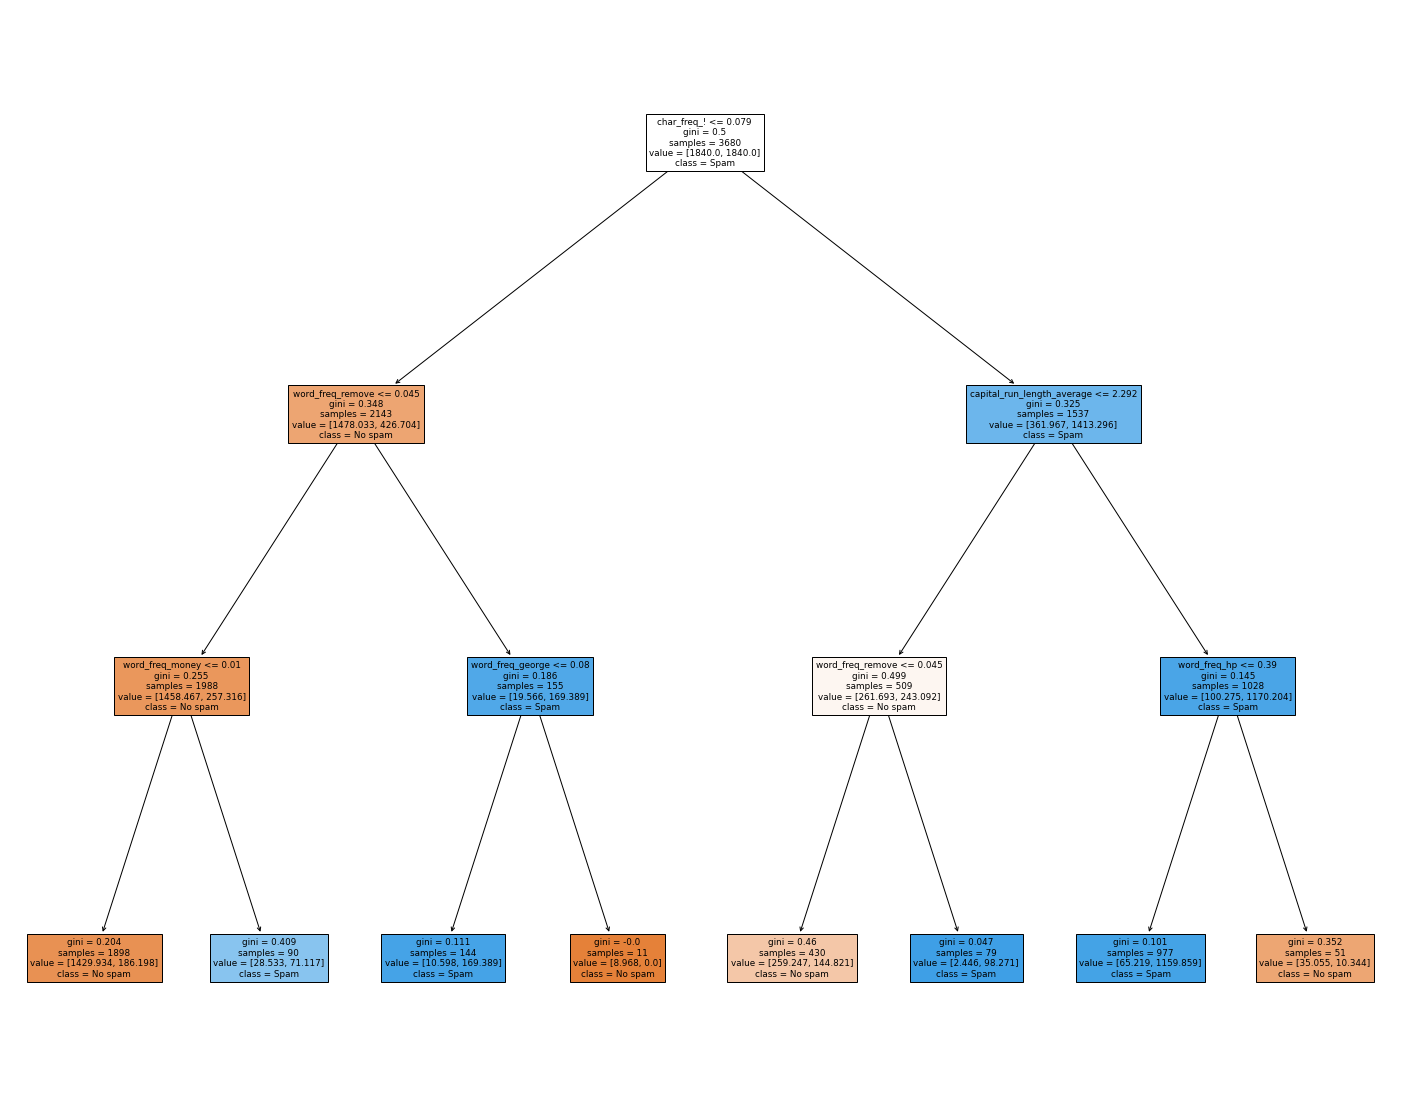

In [8]:
#Max depth here is set to 3 only in order to presume the informativeness of the visualization
model = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced', max_depth = 3)
model.fit(x_train, y_train)
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model, 
                   feature_names = x_train.columns.values.tolist(),  
                   class_names = ['No spam','Spam'],
                   filled = True)

In [9]:
cart_model = DecisionTreeClassifier(random_state = 42,max_depth = 6,
                                    min_samples_split = 10, class_weight = 'balanced')
rf_model = RandomForestClassifier(random_state = 42,max_depth = 6,
                                  min_samples_split = 10, class_weight = 'balanced')
cart_model.fit(x_train,y_train)
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=10, random_state=42)

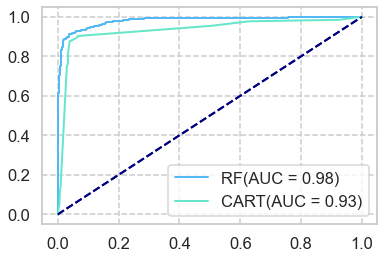

In [10]:
plotAUC([y_test,y_test], [rf_model.predict_proba(x_test)[:,1],
                cart_model.predict_proba(x_test)[:,1]],['RF','CART'])

It's obvious, that Random Forest is performing better than the CART model. On the chart above we can clearly see, that for any value of FPR(False Positive Rate) the TPR(True positive Rate) of Random Forest is always higher,so here one may even dare to say that one model is definitely better than another.

In [11]:
acc = []
acc += [accuracy_score(y_test, rf_model.predict(x_test))]
acc += [accuracy_score(y_test, cart_model.predict(x_test))]
rec = []
rec += [recall_score(y_test, rf_model.predict(x_test))]
rec += [recall_score(y_test, cart_model.predict(x_test))]
prec = []
prec += [precision_score(y_test, rf_model.predict(x_test))]
prec += [precision_score(y_test, cart_model.predict(x_test))]
f1= []
f1 += [f1_score(y_test, rf_model.predict(x_test))]
f1 += [f1_score(y_test, cart_model.predict(x_test))]
auc = []
auc += [roc_auc_score(y_test, rf_model.predict_proba(x_test)[:,1])]
auc += [roc_auc_score(y_test, cart_model.predict_proba(x_test)[:,1])]
performance = pd.DataFrame([])
performance['Accuracy'] = acc
performance['Recall'] = rec
performance['Precision'] = prec
performance['f1_score'] = f1
performance['AUC'] = auc
performance.index = ['Random Forest','CART']
performance

,Accuracy,Recall,Precision,f1_score,AUC
Random Forest,0.939197,0.905128,0.948925,0.926509,0.980236
CART,0.923996,0.876923,0.939560,0.907162,0.932768


Other metrics only confirm the above statement

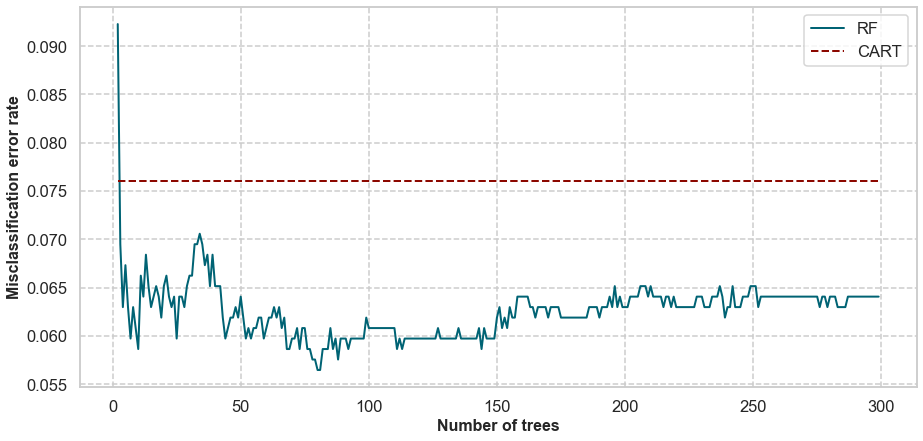

In [12]:
number_of_trees = np.arange(2,300)
size = len(number_of_trees)
non_iterable_params = {'random_state':42,'max_depth':6,
                       'min_samples_split':10,'class_weight':'balanced'}
models = [RandomForestClassifier().set_params(**non_iterable_params).set_params(**{'n_estimators' : i}).fit(x_train,y_train) for i in number_of_trees]
errors = [misclass_error(y_test,model.predict(x_test)) for model in models]
plt.figure(figsize = (15,7))
plt.plot(number_of_trees, errors, lw = 2,c = 'c', label = 'RF')
plt.plot(number_of_trees, np.repeat(misclass_error(y_test, cart_model.predict(x_test)),size), 
                                    lw = 2,ls = '--',c = 'r', label = 'CART')
plt.xlabel('Number of trees', fontsize = 16, fontweight = 'bold')
plt.ylabel('Misclassification error rate', fontsize = 16, fontweight = 'bold')
plt.legend()

### SVM

In [19]:
x_train_non_spam = x_train[y_train == 0]
y_test[y_test == 0] = -1

In [33]:
svm_model = OneClassSVM(gamma = 1e-9)
svm_model.fit(x_train_non_spam)

OneClassSVM(gamma=1e-09)

In [34]:
print('Misclassification error: ' + str(misclass_error(y_test, svm_model.predict(x_test))))

Misclassification error: 0.4581976112920738
